In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(2020);

# Declustered statistics

We will pretend that we are a mining company interested in extracting a mineral resource such as Gold (Au) from a mine $\mathcal{D}$. Based on the fact that we are trying to maximize profit, we end up collecting samples $\mathcal{S} = \{Au(x_1),Au(x_2),\ldots,Au(x_N)\}$ at nearby locations $x_1,x_2,\ldots,x_N$ where we believe we will find the mineral we are after.

Our data acquisition process suffers from *sampling bias*, and because we are successfull in what we do, most of our samples reflect high concentrations of Gold (higher than the average of the mine).

**Problem statement**:

Estimate the remaining amount of Gold in the mine $\mathcal{D}$ from the spatial samples $S$.

**QUESTION**: *Can we do any better than multiplying the sample average by the volume of the mine?*

$$\left(\frac{1}{N}\sum_{i=1}^{N} Au(x_i)\right) \times \mathcal{V}(\mathcal{D})$$

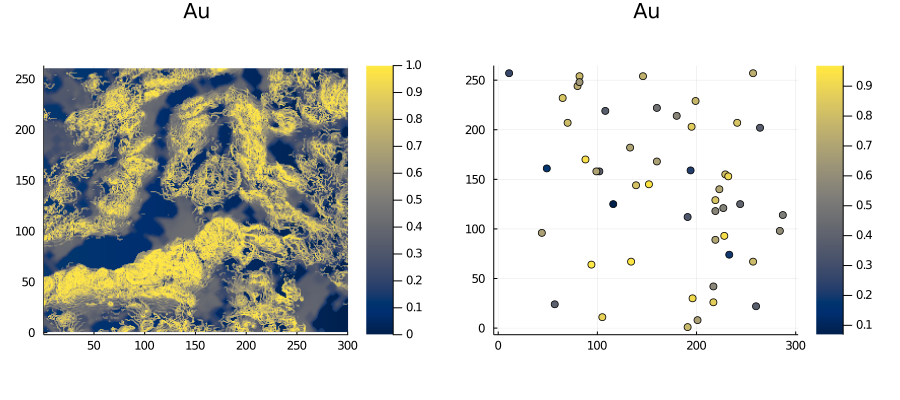

In [3]:
using GeoStats
using GeoStatsImages
using Plots; gr(c=:cividis)

Au = training_image("WalkerLakeTruth")[:,:,1]

𝒟 = RegularGridData(OrderedDict(:Au=>Au), (0.,0.), (1.,1.))

𝒮 = sample(𝒟, 50, vec(𝒟[:Au]), replace=false)

plot(plot(𝒟), plot(𝒮), size=(900,400))

The mean value of Gold in the mine is:

In [4]:
μ𝒟 = mean(𝒟[:Au])

0.5

whereas the sample average is much higher:

In [5]:
μ𝒮 = mean(𝒮[:Au])

0.6477059962307209

## Spatial declustering

Notice that besides suffering from sampling bias, our sampling process leads to samples that are *clustered in space*. Samples that are close to each other are redundant, and shouldn't receive the same "importance" in the mean estimate compared with isolated samples.

We can partition the samples into blocks of given size, count the number of samples that share a block, and use this count to assign importance weights:

$$\bar{Au} = \frac{\sum_{i=1}^N w(x_i) Au(x_i)}{\sum_{i=1}^N w(x_i)}$$

with $w(x_i)$ the weight assigned to location $x_i$.

**OBS**: $\forall i, w(x_i) = 1 \Longrightarrow \frac{1}{N}\sum_{i=1}^N Au(x_i)$.

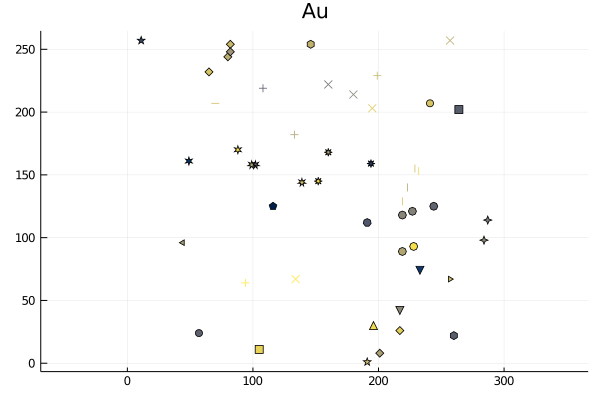

In [6]:
Π = partition(𝒮, BlockPartitioner(50., 50.))

plot(Π, colorbar=false)

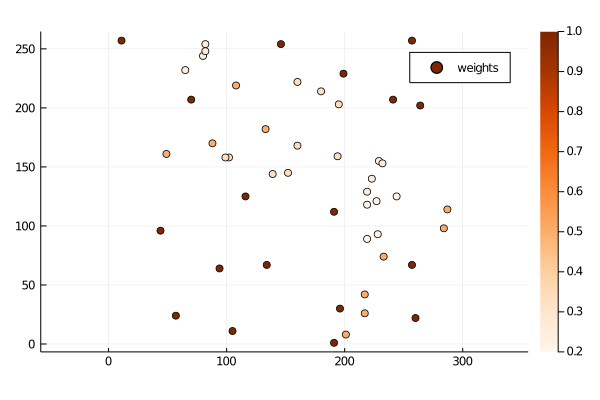

In [7]:
𝒲 = weight(𝒮, BlockWeighter(50., 50.))

plot(𝒲, c=:Oranges)

Compare the classical average to the spatial average:

In [8]:
μ𝒮 = mean(𝒮[:Au])
μℬ = mean(𝒮, :Au)

println("Classical average → ", μ𝒮)
println("Spatial average   → ", μℬ)
println("True average      → ", μ𝒟)

Classical average → 0.6477059962307209
Spatial average   → 0.5781550359878287
True average      → 0.5


And the difference in volumetric estimates:

In [9]:
𝒱 = volume(boundbox(𝒮))

(μ𝒮 - μℬ) * 𝒱

4914.1926469217915

### Declustered statistics

The idea of assigning importance weights to samples via spatial declustering is general, and holds for any statistic of interest. Hence, the term *declustered statistics*. For example, better estimates of any quantile of the Gold distribution are obtained by taking into account the spatial coordinates of the samples:

#### Classical quantile

In [10]:
quantile(𝒮[:Au], [0.25,0.50,0.75])

3-element Array{Float64,1}:
 0.48499019218195105
 0.7015602764138003
 0.8265362376440724

#### Spatial quantile

In [11]:
quantile(𝒮, :Au, [0.25,0.50,0.75])

3-element Array{Float64,1}:
 0.3783833027445125
 0.5840784236597003
 0.7933555854266376

## Selecting a block size

Notice that in the above spatial statistics we didn't need to specify the block size for partitioning the data. This is because GeoStats.jl is using a heuristic to select a "reasonable" block size for the given spatial configuration of samples.

We can plot the spatial average for increasing block sizes to notice that the sample average (i.e. uniform weights) is recovered when the block size is too small (each sample is its own block), or when the block size is too large (all samples are in a single block):

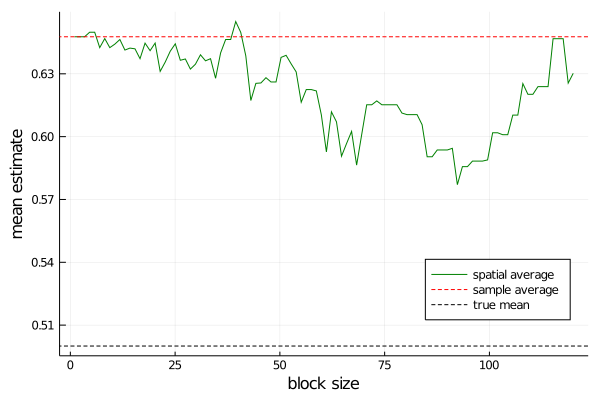

In [12]:
bs = range(1, stop=120, length=100)
μs = [mean(𝒮, :Au, b) for b in bs]

plot(xlabel="block size", ylabel="mean estimate", legend=:bottomright)
plot!(bs, μs, c=:green, label="spatial average")
hline!([μ𝒮], c=:red, ls=:dash, label="sample average")
hline!([μ𝒟], c=:black, ls=:dash, label="true mean")

**QUESTION**: *Can you devise a criterion for selecting a block size in your specific application?*

## Conclusions

- Samples can be weighted to improve estimates of spatial resources via the concept of spatial declustering.
- [GeoStats.jl](https://github.com/JuliaEarth/GeoStats.jl) changes the semantics of statistics such as `mean`, `var`, and `quantile` in a spatial context.
- The framework generalizes various operations and statistics to work with any spatial data configuration.